In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../_data/Tavares2017.csv')
data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 2 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)
data_df['sbj'] += 1

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])


min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'choice']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(ts_df[['rt', 'choice']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(21313, 4) (9151, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 87        
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 906s 906s/step - loss: 112767.2109
Epoch 2/3000
1/1 [==============================] - 0s 361ms/step - loss: 112331.5938
Epoch 3/3000
1/1 [==============================] - 0s 155ms/step - loss: 112014.4297
Epoch 4/3000
1/1 [==============================] - 0s 145ms/step - loss: 111748.3438
Epoch 5/3000
1/1 [==============================] - 0s 138ms/step - loss: 111511.5938
Epoch 6/3000
1/1 [==============================] - 0s 140ms/step - loss: 111293.8203
Epoch 7/3000
1/1 [==============================] - 0s 149ms/step - loss: 111088.8203
Epoch 8/3000
1/1 [==============================] - 0s 135ms/step - loss: 110892.7031
Epoch 9/3000
1/1 [==============================] - 0s 133ms/step - loss: 110703.1797
Epoch 10/3000
1/1 [==============================] - 0s 144ms/step - loss: 110518.7266
Epoch 11/3000
1/1 [==============================] - 0s 301ms/step - loss: 110338.2812
Epoch 12/3000
1/1 [==============================] 

1/1 [==============================] - 0s 236ms/step - loss: 99904.6875
Epoch 96/3000
1/1 [==============================] - 0s 275ms/step - loss: 99816.4062
Epoch 97/3000
1/1 [==============================] - 0s 230ms/step - loss: 99728.6719
Epoch 98/3000
1/1 [==============================] - 0s 294ms/step - loss: 99641.4844
Epoch 99/3000
1/1 [==============================] - 0s 325ms/step - loss: 99554.8047
Epoch 100/3000
1/1 [==============================] - 0s 215ms/step - loss: 99468.6484
Epoch 101/3000
1/1 [==============================] - 0s 204ms/step - loss: 99383.0156
Epoch 102/3000
1/1 [==============================] - 0s 220ms/step - loss: 99297.8984
Epoch 103/3000
1/1 [==============================] - 0s 284ms/step - loss: 99213.2969
Epoch 104/3000
1/1 [==============================] - 0s 224ms/step - loss: 99129.1875
Epoch 105/3000
1/1 [==============================] - 0s 220ms/step - loss: 99045.5781
Epoch 106/3000
1/1 [==============================] - 0s 254ms

1/1 [==============================] - 0s 206ms/step - loss: 93386.7578
Epoch 190/3000
1/1 [==============================] - 0s 212ms/step - loss: 93331.9219
Epoch 191/3000
1/1 [==============================] - 0s 249ms/step - loss: 93277.3281
Epoch 192/3000
1/1 [==============================] - 0s 216ms/step - loss: 93222.9453
Epoch 193/3000
1/1 [==============================] - 0s 211ms/step - loss: 93168.7891
Epoch 194/3000
1/1 [==============================] - 0s 224ms/step - loss: 93114.8594
Epoch 195/3000
1/1 [==============================] - 0s 219ms/step - loss: 93061.1406
Epoch 196/3000
1/1 [==============================] - 0s 252ms/step - loss: 93007.6328
Epoch 197/3000
1/1 [==============================] - 0s 294ms/step - loss: 92954.3516
Epoch 198/3000
1/1 [==============================] - 0s 255ms/step - loss: 92901.2656
Epoch 199/3000
1/1 [==============================] - 0s 227ms/step - loss: 92848.4062
Epoch 200/3000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 223ms/step - loss: 89013.2656
Epoch 284/3000
1/1 [==============================] - 0s 473ms/step - loss: 88973.3281
Epoch 285/3000
1/1 [==============================] - 0s 355ms/step - loss: 88933.4609
Epoch 286/3000
1/1 [==============================] - 0s 276ms/step - loss: 88893.6875
Epoch 287/3000
1/1 [==============================] - 0s 329ms/step - loss: 88853.9922
Epoch 288/3000
1/1 [==============================] - 0s 236ms/step - loss: 88814.3750
Epoch 289/3000
1/1 [==============================] - 0s 261ms/step - loss: 88774.8359
Epoch 290/3000
1/1 [==============================] - 0s 356ms/step - loss: 88735.3672
Epoch 291/3000
1/1 [==============================] - 0s 233ms/step - loss: 88695.9688
Epoch 292/3000
1/1 [==============================] - 0s 226ms/step - loss: 88656.6250
Epoch 293/3000
1/1 [==============================] - 0s 244ms/step - loss: 88617.3438
Epoch 294/3000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 258ms/step - loss: 85377.7188
Epoch 378/3000
1/1 [==============================] - 0s 236ms/step - loss: 85337.8750
Epoch 379/3000
1/1 [==============================] - 0s 272ms/step - loss: 85297.4219
Epoch 380/3000
1/1 [==============================] - 0s 294ms/step - loss: 85256.2266
Epoch 381/3000
1/1 [==============================] - 0s 280ms/step - loss: 85214.1094
Epoch 382/3000
1/1 [==============================] - 0s 238ms/step - loss: 85170.9375
Epoch 383/3000
1/1 [==============================] - 0s 266ms/step - loss: 85126.5000
Epoch 384/3000
1/1 [==============================] - 0s 337ms/step - loss: 85080.6406
Epoch 385/3000
1/1 [==============================] - 0s 327ms/step - loss: 85033.1953
Epoch 386/3000
1/1 [==============================] - 0s 328ms/step - loss: 84984.0234
Epoch 387/3000
1/1 [==============================] - 0s 315ms/step - loss: 84933.0156
Epoch 388/3000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 224ms/step - loss: 80225.7578
Epoch 472/3000
1/1 [==============================] - 0s 218ms/step - loss: 80172.1406
Epoch 473/3000
1/1 [==============================] - 0s 207ms/step - loss: 80118.5312
Epoch 474/3000
1/1 [==============================] - 0s 235ms/step - loss: 80064.9375
Epoch 475/3000
1/1 [==============================] - 0s 247ms/step - loss: 80011.3750
Epoch 476/3000
1/1 [==============================] - 0s 244ms/step - loss: 79957.8125
Epoch 477/3000
1/1 [==============================] - 0s 282ms/step - loss: 79904.2812
Epoch 478/3000
1/1 [==============================] - 0s 215ms/step - loss: 79850.7656
Epoch 479/3000
1/1 [==============================] - 0s 225ms/step - loss: 79797.3125
Epoch 480/3000
1/1 [==============================] - 0s 344ms/step - loss: 79744.2656
Epoch 481/3000
1/1 [==============================] - 0s 424ms/step - loss: 79692.4531
Epoch 482/3000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 320ms/step - loss: 75296.0938
Epoch 566/3000
1/1 [==============================] - 0s 425ms/step - loss: 75243.8281
Epoch 567/3000
1/1 [==============================] - 0s 253ms/step - loss: 75191.7031
Epoch 568/3000
1/1 [==============================] - 0s 288ms/step - loss: 75139.4375
Epoch 569/3000
1/1 [==============================] - 0s 268ms/step - loss: 75087.3203
Epoch 570/3000
1/1 [==============================] - 0s 277ms/step - loss: 75035.0469
Epoch 571/3000
1/1 [==============================] - 0s 448ms/step - loss: 74982.9297
Epoch 572/3000
1/1 [==============================] - 1s 560ms/step - loss: 74930.6562
Epoch 573/3000
1/1 [==============================] - 0s 335ms/step - loss: 74878.5312
Epoch 574/3000
1/1 [==============================] - 0s 324ms/step - loss: 74826.2656
Epoch 575/3000
1/1 [==============================] - 0s 376ms/step - loss: 74774.1406
Epoch 576/3000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 214ms/step - loss: 70401.8047
Epoch 660/3000
1/1 [==============================] - 0s 208ms/step - loss: 70350.4531
Epoch 661/3000
1/1 [==============================] - 0s 220ms/step - loss: 70299.1641
Epoch 662/3000
1/1 [==============================] - 0s 218ms/step - loss: 70247.8516
Epoch 663/3000
1/1 [==============================] - 0s 214ms/step - loss: 70196.6250
Epoch 664/3000
1/1 [==============================] - 0s 215ms/step - loss: 70145.3750
Epoch 665/3000
1/1 [==============================] - 0s 207ms/step - loss: 70094.2031
Epoch 666/3000
1/1 [==============================] - 0s 219ms/step - loss: 70043.0156
Epoch 667/3000
1/1 [==============================] - 0s 237ms/step - loss: 69991.8906
Epoch 668/3000
1/1 [==============================] - 0s 275ms/step - loss: 69940.7500
Epoch 669/3000
1/1 [==============================] - 0s 242ms/step - loss: 69889.6875
Epoch 670/3000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 211ms/step - loss: 65770.1094
Epoch 754/3000
1/1 [==============================] - 0s 228ms/step - loss: 65724.7656
Epoch 755/3000
1/1 [==============================] - 0s 248ms/step - loss: 65680.3906
Epoch 756/3000
1/1 [==============================] - 0s 225ms/step - loss: 65635.2578
Epoch 757/3000
1/1 [==============================] - 0s 233ms/step - loss: 65591.1328
Epoch 758/3000
1/1 [==============================] - 0s 236ms/step - loss: 65546.2188
Epoch 759/3000
1/1 [==============================] - 0s 221ms/step - loss: 65502.3398
Epoch 760/3000
1/1 [==============================] - 0s 238ms/step - loss: 65457.6484
Epoch 761/3000
1/1 [==============================] - 0s 214ms/step - loss: 65414.0195
Epoch 762/3000
1/1 [==============================] - 0s 221ms/step - loss: 65369.5508
Epoch 763/3000
1/1 [==============================] - 0s 214ms/step - loss: 65326.1602
Epoch 764/3000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 224ms/step - loss: 62050.7148
Epoch 848/3000
1/1 [==============================] - 0s 217ms/step - loss: 62015.7852
Epoch 849/3000
1/1 [==============================] - 0s 225ms/step - loss: 61982.2734
Epoch 850/3000
1/1 [==============================] - 0s 217ms/step - loss: 61947.5664
Epoch 851/3000
1/1 [==============================] - 0s 233ms/step - loss: 61914.2617
Epoch 852/3000
1/1 [==============================] - 0s 215ms/step - loss: 61879.7734
Epoch 853/3000
1/1 [==============================] - 0s 227ms/step - loss: 61846.6719
Epoch 854/3000
1/1 [==============================] - 0s 222ms/step - loss: 61812.3984
Epoch 855/3000
1/1 [==============================] - 0s 226ms/step - loss: 61779.5039
Epoch 856/3000
1/1 [==============================] - 0s 240ms/step - loss: 61745.4570
Epoch 857/3000
1/1 [==============================] - 0s 259ms/step - loss: 61712.7695
Epoch 858/3000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 212ms/step - loss: 59282.1992
Epoch 942/3000
1/1 [==============================] - 0s 208ms/step - loss: 59256.9180
Epoch 943/3000
1/1 [==============================] - 0s 206ms/step - loss: 59232.7344
Epoch 944/3000
1/1 [==============================] - 0s 211ms/step - loss: 59207.6289
Epoch 945/3000
1/1 [==============================] - 0s 213ms/step - loss: 59183.6367
Epoch 946/3000
1/1 [==============================] - 0s 243ms/step - loss: 59158.7148
Epoch 947/3000
1/1 [==============================] - 0s 234ms/step - loss: 59134.9023
Epoch 948/3000
1/1 [==============================] - 0s 220ms/step - loss: 59110.1445
Epoch 949/3000
1/1 [==============================] - 0s 226ms/step - loss: 59086.5078
Epoch 950/3000
1/1 [==============================] - 0s 427ms/step - loss: 59061.9297
Epoch 951/3000
1/1 [==============================] - 0s 422ms/step - loss: 59038.4805
Epoch 952/3000
1/1 [==============================] - 0s 2

Epoch 1035/3000
1/1 [==============================] - 0s 227ms/step - loss: 57300.5898
Epoch 1036/3000
1/1 [==============================] - 0s 215ms/step - loss: 57282.1094
Epoch 1037/3000
1/1 [==============================] - 0s 209ms/step - loss: 57264.9297
Epoch 1038/3000
1/1 [==============================] - 0s 223ms/step - loss: 57246.5703
Epoch 1039/3000
1/1 [==============================] - 0s 214ms/step - loss: 57229.4766
Epoch 1040/3000
1/1 [==============================] - 0s 215ms/step - loss: 57211.2422
Epoch 1041/3000
1/1 [==============================] - 0s 224ms/step - loss: 57194.2695
Epoch 1042/3000
1/1 [==============================] - 0s 217ms/step - loss: 57176.1406
Epoch 1043/3000
1/1 [==============================] - 0s 207ms/step - loss: 57159.2695
Epoch 1044/3000
1/1 [==============================] - 0s 226ms/step - loss: 57141.2461
Epoch 1045/3000
1/1 [==============================] - 0s 269ms/step - loss: 57124.4922
Epoch 1046/3000
1/1 [===========

1/1 [==============================] - 0s 216ms/step - loss: 55871.7500
Epoch 1129/3000
1/1 [==============================] - 0s 215ms/step - loss: 55859.2031
Epoch 1130/3000
1/1 [==============================] - 0s 215ms/step - loss: 55846.0391
Epoch 1131/3000
1/1 [==============================] - 0s 209ms/step - loss: 55833.5352
Epoch 1132/3000
1/1 [==============================] - 0s 221ms/step - loss: 55820.6289
Epoch 1133/3000
1/1 [==============================] - 0s 228ms/step - loss: 55808.2109
Epoch 1134/3000
1/1 [==============================] - 0s 217ms/step - loss: 55795.2305
Epoch 1135/3000
1/1 [==============================] - 0s 232ms/step - loss: 55782.9336
Epoch 1136/3000
1/1 [==============================] - 0s 224ms/step - loss: 55770.2773
Epoch 1137/3000
1/1 [==============================] - 0s 212ms/step - loss: 55758.1055
Epoch 1138/3000
1/1 [==============================] - 0s 257ms/step - loss: 55745.5000
Epoch 1139/3000
1/1 [===========================

1/1 [==============================] - 0s 348ms/step - loss: 54869.4453
Epoch 1222/3000
1/1 [==============================] - 0s 214ms/step - loss: 54859.5625
Epoch 1223/3000
1/1 [==============================] - 0s 211ms/step - loss: 54850.4883
Epoch 1224/3000
1/1 [==============================] - 0s 217ms/step - loss: 54841.8242
Epoch 1225/3000
1/1 [==============================] - 0s 206ms/step - loss: 54833.4141
Epoch 1226/3000
1/1 [==============================] - 0s 203ms/step - loss: 54823.9609
Epoch 1227/3000
1/1 [==============================] - 0s 223ms/step - loss: 54815.9688
Epoch 1228/3000
1/1 [==============================] - 0s 219ms/step - loss: 54807.3516
Epoch 1229/3000
1/1 [==============================] - 0s 229ms/step - loss: 54799.2383
Epoch 1230/3000
1/1 [==============================] - 0s 214ms/step - loss: 54794.4609
Epoch 1231/3000
1/1 [==============================] - 0s 242ms/step - loss: 54788.6406
Epoch 1232/3000
1/1 [===========================

Epoch 1315/3000
1/1 [==============================] - 0s 217ms/step - loss: 54161.5117
Epoch 1316/3000
1/1 [==============================] - 0s 216ms/step - loss: 54133.6953
Epoch 1317/3000
1/1 [==============================] - 0s 211ms/step - loss: 54119.8945
Epoch 1318/3000
1/1 [==============================] - 0s 223ms/step - loss: 54107.0117
Epoch 1319/3000
1/1 [==============================] - 0s 207ms/step - loss: 54100.7656
Epoch 1320/3000
1/1 [==============================] - 0s 240ms/step - loss: 54091.5742
Epoch 1321/3000
1/1 [==============================] - 0s 227ms/step - loss: 54086.9258
Epoch 1322/3000
1/1 [==============================] - 0s 219ms/step - loss: nan
Epoch 1323/3000
1/1 [==============================] - 0s 228ms/step - loss: 54072.8320
Epoch 1324/3000
1/1 [==============================] - 0s 230ms/step - loss: nan
Epoch 1325/3000
1/1 [==============================] - 0s 259ms/step - loss: 54077.8828
Epoch 1326/3000
1/1 [=========================

1/1 [==============================] - 0s 223ms/step - loss: 53619.7617
Epoch 1410/3000
1/1 [==============================] - 0s 224ms/step - loss: nan
Epoch 1411/3000
1/1 [==============================] - 0s 254ms/step - loss: nan
Epoch 1412/3000
1/1 [==============================] - 0s 219ms/step - loss: 53713.4570
Epoch 1413/3000
1/1 [==============================] - 0s 240ms/step - loss: 53659.7656
Epoch 1414/3000
1/1 [==============================] - 0s 238ms/step - loss: 53618.1797
Epoch 1415/3000
1/1 [==============================] - 0s 265ms/step - loss: nan
Epoch 1416/3000
1/1 [==============================] - 0s 250ms/step - loss: 53595.7148
Epoch 1417/3000
1/1 [==============================] - 0s 248ms/step - loss: nan
Epoch 1418/3000
1/1 [==============================] - 0s 227ms/step - loss: 53579.7578
Epoch 1419/3000
1/1 [==============================] - 0s 272ms/step - loss: 53577.8242
Epoch 1420/3000
1/1 [==============================] - 0s 307ms/step - loss:

1/1 [==============================] - 0s 284ms/step - loss: 53219.8828
Epoch 1503/3000
1/1 [==============================] - 0s 384ms/step - loss: nan
Epoch 1504/3000
1/1 [==============================] - 0s 271ms/step - loss: 53209.7656
Epoch 1505/3000
1/1 [==============================] - 0s 232ms/step - loss: nan
Epoch 1506/3000
1/1 [==============================] - 0s 241ms/step - loss: 53245.8984
Epoch 1507/3000
1/1 [==============================] - 0s 260ms/step - loss: 53280.5977
Epoch 1508/3000
1/1 [==============================] - 0s 234ms/step - loss: 53317.9258
Epoch 1509/3000
1/1 [==============================] - 0s 275ms/step - loss: 53291.4258
Epoch 1510/3000
1/1 [==============================] - 0s 243ms/step - loss: 53250.1016
Epoch 1511/3000
1/1 [==============================] - 0s 286ms/step - loss: 53216.5469
Epoch 1512/3000
1/1 [==============================] - 0s 254ms/step - loss: 53197.5625
Epoch 1513/3000
1/1 [==============================] - 0s 223m

1/1 [==============================] - 0s 230ms/step - loss: 52935.5898
Epoch 1596/3000
1/1 [==============================] - 0s 216ms/step - loss: 52913.5703
Epoch 1597/3000
1/1 [==============================] - 0s 231ms/step - loss: 52904.8398
Epoch 1598/3000
1/1 [==============================] - 0s 227ms/step - loss: 52905.7109
Epoch 1599/3000
1/1 [==============================] - 0s 234ms/step - loss: 52899.8555
Epoch 1600/3000
1/1 [==============================] - 0s 208ms/step - loss: 52909.2461
Epoch 1601/3000
1/1 [==============================] - 0s 231ms/step - loss: 52922.4102
Epoch 1602/3000
1/1 [==============================] - 0s 217ms/step - loss: 52951.0781
Epoch 1603/3000
1/1 [==============================] - 0s 223ms/step - loss: nan
Epoch 1604/3000
1/1 [==============================] - 0s 213ms/step - loss: 52994.4727
Epoch 1605/3000
1/1 [==============================] - 0s 212ms/step - loss: 52957.4414
Epoch 1606/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 211ms/step - loss: 52689.6484
Epoch 1690/3000
1/1 [==============================] - 0s 211ms/step - loss: 52695.5156
Epoch 1691/3000
1/1 [==============================] - 0s 204ms/step - loss: 52697.3828
Epoch 1692/3000
1/1 [==============================] - 0s 212ms/step - loss: 52735.1250
Epoch 1693/3000
1/1 [==============================] - 0s 206ms/step - loss: 52708.3984
Epoch 1694/3000
1/1 [==============================] - 0s 204ms/step - loss: 52703.2734
Epoch 1695/3000
1/1 [==============================] - 0s 202ms/step - loss: 52689.0820
Epoch 1696/3000
1/1 [==============================] - 0s 243ms/step - loss: 52689.1484
Epoch 1697/3000
1/1 [==============================] - 0s 222ms/step - loss: 52679.4844
Epoch 1698/3000
1/1 [==============================] - 0s 222ms/step - loss: 52686.5234
Epoch 1699/3000
1/1 [==============================] - 0s 232ms/step - loss: nan
Epoch 1700/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 209ms/step - loss: nan
Epoch 1784/3000
1/1 [==============================] - 0s 210ms/step - loss: 52551.1328
Epoch 1785/3000
1/1 [==============================] - 0s 222ms/step - loss: 52511.1289
Epoch 1786/3000
1/1 [==============================] - 0s 214ms/step - loss: 52507.8203
Epoch 1787/3000
1/1 [==============================] - 0s 240ms/step - loss: 52484.2930
Epoch 1788/3000
1/1 [==============================] - 0s 225ms/step - loss: 52483.4883
Epoch 1789/3000
1/1 [==============================] - 0s 207ms/step - loss: 52479.0859
Epoch 1790/3000
1/1 [==============================] - 0s 209ms/step - loss: 52480.5156
Epoch 1791/3000
1/1 [==============================] - 0s 211ms/step - loss: 52478.9180
Epoch 1792/3000
1/1 [==============================] - 0s 213ms/step - loss: 52485.9766
Epoch 1793/3000
1/1 [==============================] - 0s 220ms/step - loss: 52492.0938
Epoch 1794/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 224ms/step - loss: 52401.3477
Epoch 1877/3000
1/1 [==============================] - 0s 222ms/step - loss: 52395.3867
Epoch 1878/3000
1/1 [==============================] - 0s 226ms/step - loss: 52391.0898
Epoch 1879/3000
1/1 [==============================] - 0s 209ms/step - loss: 52373.1172
Epoch 1880/3000
1/1 [==============================] - 0s 200ms/step - loss: 52358.2930
Epoch 1881/3000
1/1 [==============================] - 0s 231ms/step - loss: 52350.7500
Epoch 1882/3000
1/1 [==============================] - 0s 205ms/step - loss: 52355.2266
Epoch 1883/3000
1/1 [==============================] - 0s 213ms/step - loss: 52355.0195
Epoch 1884/3000
1/1 [==============================] - 0s 215ms/step - loss: 52338.7891
Epoch 1885/3000
1/1 [==============================] - 0s 208ms/step - loss: 52526.1914
Epoch 1886/3000
1/1 [==============================] - 0s 208ms/step - loss: 52445.8281
Epoch 1887/3000
1/1 [===========================

1/1 [==============================] - 0s 307ms/step - loss: 52251.3516
Epoch 1970/3000
1/1 [==============================] - 0s 238ms/step - loss: 52264.1797
Epoch 1971/3000
1/1 [==============================] - 0s 206ms/step - loss: 52287.3164
Epoch 1972/3000
1/1 [==============================] - 0s 201ms/step - loss: 52287.8750
Epoch 1973/3000
1/1 [==============================] - 0s 215ms/step - loss: 52267.6875
Epoch 1974/3000
1/1 [==============================] - 0s 215ms/step - loss: 52254.6641
Epoch 1975/3000
1/1 [==============================] - 0s 221ms/step - loss: 52241.7305
Epoch 1976/3000
1/1 [==============================] - 0s 214ms/step - loss: nan
Epoch 1977/3000
1/1 [==============================] - 0s 205ms/step - loss: 52222.8125
Epoch 1978/3000
1/1 [==============================] - 0s 220ms/step - loss: nan
Epoch 1979/3000
1/1 [==============================] - 0s 215ms/step - loss: 52217.6953
Epoch 1980/3000
1/1 [==============================] - 0s 212m

1/1 [==============================] - 0s 213ms/step - loss: 52144.5039
Epoch 2064/3000
1/1 [==============================] - 0s 204ms/step - loss: 52128.2852
Epoch 2065/3000
1/1 [==============================] - 0s 211ms/step - loss: 52132.1250
Epoch 2066/3000
1/1 [==============================] - 0s 207ms/step - loss: 52137.5156
Epoch 2067/3000
1/1 [==============================] - 0s 210ms/step - loss: 52152.5000
Epoch 2068/3000
1/1 [==============================] - 0s 236ms/step - loss: 52175.3594
Epoch 2069/3000
1/1 [==============================] - 0s 207ms/step - loss: 52193.0898
Epoch 2070/3000
1/1 [==============================] - 0s 283ms/step - loss: 52203.1250
Epoch 2071/3000
1/1 [==============================] - 0s 284ms/step - loss: 52179.6289
Epoch 2072/3000
1/1 [==============================] - 0s 269ms/step - loss: 52164.8320
Epoch 2073/3000
1/1 [==============================] - 0s 218ms/step - loss: 52142.4609
Epoch 2074/3000
1/1 [===========================

1/1 [==============================] - 0s 293ms/step - loss: nan
Epoch 2158/3000
1/1 [==============================] - 0s 249ms/step - loss: 52044.2188
Epoch 2159/3000
1/1 [==============================] - 0s 235ms/step - loss: nan
Epoch 2160/3000
1/1 [==============================] - 0s 243ms/step - loss: nan
Epoch 2161/3000
1/1 [==============================] - 0s 235ms/step - loss: 52030.4883
Epoch 2162/3000
1/1 [==============================] - 0s 223ms/step - loss: nan
Epoch 2163/3000
1/1 [==============================] - 0s 237ms/step - loss: 52073.7969
Epoch 2164/3000
1/1 [==============================] - 0s 213ms/step - loss: 52094.1641
Epoch 2165/3000
1/1 [==============================] - 0s 212ms/step - loss: 52131.9922
Epoch 2166/3000
1/1 [==============================] - 0s 213ms/step - loss: 52134.0234
Epoch 2167/3000
1/1 [==============================] - 0s 208ms/step - loss: 52122.5195
Epoch 2168/3000
1/1 [==============================] - 0s 203ms/step - loss:

1/1 [==============================] - 0s 230ms/step - loss: nan
Epoch 2252/3000
1/1 [==============================] - 0s 228ms/step - loss: 51995.0547
Epoch 2253/3000
1/1 [==============================] - 0s 244ms/step - loss: 51975.1875
Epoch 2254/3000
1/1 [==============================] - 0s 216ms/step - loss: 51969.8633
Epoch 2255/3000
1/1 [==============================] - 0s 229ms/step - loss: 51965.8672
Epoch 2256/3000
1/1 [==============================] - 0s 220ms/step - loss: 51960.2695
Epoch 2257/3000
1/1 [==============================] - 0s 204ms/step - loss: 51959.5156
Epoch 2258/3000
1/1 [==============================] - 0s 218ms/step - loss: 51960.3320
Epoch 2259/3000
1/1 [==============================] - 0s 220ms/step - loss: 51957.5938
Epoch 2260/3000
1/1 [==============================] - 0s 211ms/step - loss: 51953.7617
Epoch 2261/3000
1/1 [==============================] - 0s 214ms/step - loss: 51954.9922
Epoch 2262/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 258ms/step - loss: 51908.6523
Epoch 2346/3000
1/1 [==============================] - 0s 250ms/step - loss: 51895.9414
Epoch 2347/3000
1/1 [==============================] - 0s 279ms/step - loss: 51896.2188
Epoch 2348/3000
1/1 [==============================] - 0s 327ms/step - loss: 51894.5391
Epoch 2349/3000
1/1 [==============================] - 0s 245ms/step - loss: nan
Epoch 2350/3000
1/1 [==============================] - 0s 237ms/step - loss: nan
Epoch 2351/3000
1/1 [==============================] - 0s 304ms/step - loss: 51895.3672
Epoch 2352/3000
1/1 [==============================] - 0s 244ms/step - loss: 51983.1328
Epoch 2353/3000
1/1 [==============================] - 0s 226ms/step - loss: 52054.9141
Epoch 2354/3000
1/1 [==============================] - 0s 216ms/step - loss: 52004.6406
Epoch 2355/3000
1/1 [==============================] - 0s 251ms/step - loss: nan
Epoch 2356/3000
1/1 [==============================] - 0s 223ms/step 

1/1 [==============================] - 0s 245ms/step - loss: 51849.1055
Epoch 2440/3000
1/1 [==============================] - 0s 301ms/step - loss: nan
Epoch 2441/3000
1/1 [==============================] - 0s 305ms/step - loss: 51869.2070
Epoch 2442/3000
1/1 [==============================] - 0s 240ms/step - loss: 51916.8477
Epoch 2443/3000
1/1 [==============================] - 0s 310ms/step - loss: 51974.5117
Epoch 2444/3000
1/1 [==============================] - 0s 409ms/step - loss: 51944.2422
Epoch 2445/3000
1/1 [==============================] - 0s 321ms/step - loss: 51880.6719
Epoch 2446/3000
1/1 [==============================] - 0s 325ms/step - loss: 51852.5742
Epoch 2447/3000
1/1 [==============================] - 0s 254ms/step - loss: 51840.2109
Epoch 2448/3000
1/1 [==============================] - 0s 242ms/step - loss: 51838.0664
Epoch 2449/3000
1/1 [==============================] - 0s 285ms/step - loss: 51834.3047
Epoch 2450/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 243ms/step - loss: nan
Epoch 2533/3000
1/1 [==============================] - 0s 268ms/step - loss: 51880.0508
Epoch 2534/3000
1/1 [==============================] - 0s 280ms/step - loss: 51812.4258
Epoch 2535/3000
1/1 [==============================] - 0s 211ms/step - loss: 51790.4766
Epoch 2536/3000
1/1 [==============================] - 0s 246ms/step - loss: 51789.0469
Epoch 2537/3000
1/1 [==============================] - 0s 227ms/step - loss: 51804.0312
Epoch 2538/3000
1/1 [==============================] - 0s 226ms/step - loss: 51789.8086
Epoch 2539/3000
1/1 [==============================] - 0s 230ms/step - loss: 51787.2500
Epoch 2540/3000
1/1 [==============================] - 0s 214ms/step - loss: 51783.3594
Epoch 2541/3000
1/1 [==============================] - 0s 228ms/step - loss: 51788.5117
Epoch 2542/3000
1/1 [==============================] - 0s 243ms/step - loss: 51783.2461
Epoch 2543/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 309ms/step - loss: 51793.5508
Epoch 2626/3000
1/1 [==============================] - 0s 380ms/step - loss: 51769.0234
Epoch 2627/3000
1/1 [==============================] - 1s 553ms/step - loss: 51756.0234
Epoch 2628/3000
1/1 [==============================] - 0s 365ms/step - loss: 51744.5039
Epoch 2629/3000
1/1 [==============================] - 0s 344ms/step - loss: nan
Epoch 2630/3000
1/1 [==============================] - 0s 371ms/step - loss: 51752.9609
Epoch 2631/3000
1/1 [==============================] - 0s 237ms/step - loss: 51758.4648
Epoch 2632/3000
1/1 [==============================] - 0s 481ms/step - loss: 51762.8203
Epoch 2633/3000
1/1 [==============================] - 0s 394ms/step - loss: nan
Epoch 2634/3000
1/1 [==============================] - 0s 246ms/step - loss: 51845.8984
Epoch 2635/3000
1/1 [==============================] - 0s 410ms/step - loss: 51815.4609
Epoch 2636/3000
1/1 [==============================] - 0s 276m

1/1 [==============================] - 0s 280ms/step - loss: nan
Epoch 2720/3000
1/1 [==============================] - 0s 286ms/step - loss: nan
Epoch 2721/3000
1/1 [==============================] - 0s 233ms/step - loss: 51715.6328
Epoch 2722/3000
1/1 [==============================] - 0s 235ms/step - loss: 51700.2891
Epoch 2723/3000
1/1 [==============================] - 0s 323ms/step - loss: 51694.7109
Epoch 2724/3000
1/1 [==============================] - 0s 287ms/step - loss: 51693.8750
Epoch 2725/3000
1/1 [==============================] - 0s 374ms/step - loss: 51690.4023
Epoch 2726/3000
1/1 [==============================] - 0s 238ms/step - loss: 51692.9844
Epoch 2727/3000
1/1 [==============================] - 0s 211ms/step - loss: 51691.0352
Epoch 2728/3000
1/1 [==============================] - 0s 220ms/step - loss: 51699.9961
Epoch 2729/3000
1/1 [==============================] - 0s 247ms/step - loss: nan
Epoch 2730/3000
1/1 [==============================] - 0s 233ms/step 

1/1 [==============================] - 0s 232ms/step - loss: nan
Epoch 2814/3000
1/1 [==============================] - 0s 260ms/step - loss: 51676.5352
Epoch 2815/3000
1/1 [==============================] - 0s 220ms/step - loss: 51667.9062
Epoch 2816/3000
1/1 [==============================] - 0s 209ms/step - loss: 51671.8711
Epoch 2817/3000
1/1 [==============================] - 0s 241ms/step - loss: nan
Epoch 2818/3000
1/1 [==============================] - 0s 316ms/step - loss: 51680.0000
Epoch 2819/3000
1/1 [==============================] - 0s 274ms/step - loss: 51688.8906
Epoch 2820/3000
1/1 [==============================] - 0s 265ms/step - loss: 51702.5156
Epoch 2821/3000
1/1 [==============================] - 0s 303ms/step - loss: nan
Epoch 2822/3000
1/1 [==============================] - 0s 257ms/step - loss: 51717.5000
Epoch 2823/3000
1/1 [==============================] - 0s 281ms/step - loss: nan
Epoch 2824/3000
1/1 [==============================] - 0s 258ms/step - loss:

1/1 [==============================] - 0s 282ms/step - loss: 51708.2266
Epoch 2909/3000
1/1 [==============================] - 0s 374ms/step - loss: 51690.1211
Epoch 2910/3000
1/1 [==============================] - 0s 287ms/step - loss: 51675.7148
Epoch 2911/3000
1/1 [==============================] - 0s 334ms/step - loss: nan
Epoch 2912/3000
1/1 [==============================] - 0s 279ms/step - loss: 51636.9297
Epoch 2913/3000
1/1 [==============================] - 0s 284ms/step - loss: 51633.4141
Epoch 2914/3000
1/1 [==============================] - 0s 308ms/step - loss: 51637.7344
Epoch 2915/3000
1/1 [==============================] - 0s 307ms/step - loss: 51624.9180
Epoch 2916/3000
1/1 [==============================] - 0s 266ms/step - loss: nan
Epoch 2917/3000
1/1 [==============================] - 0s 367ms/step - loss: 51641.8516
Epoch 2918/3000
1/1 [==============================] - 0s 319ms/step - loss: 51656.4531
Epoch 2919/3000
1/1 [==============================] - 0s 275m

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

286/286 [==============================] - 0s 342us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'val1': [],
            'val2':[],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['val1'].append(ts_df.item_value_0[s])
        pred_bhv['val2'].append(ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv['diff'] = pred_bhv['val2'] - pred_bhv['val1']

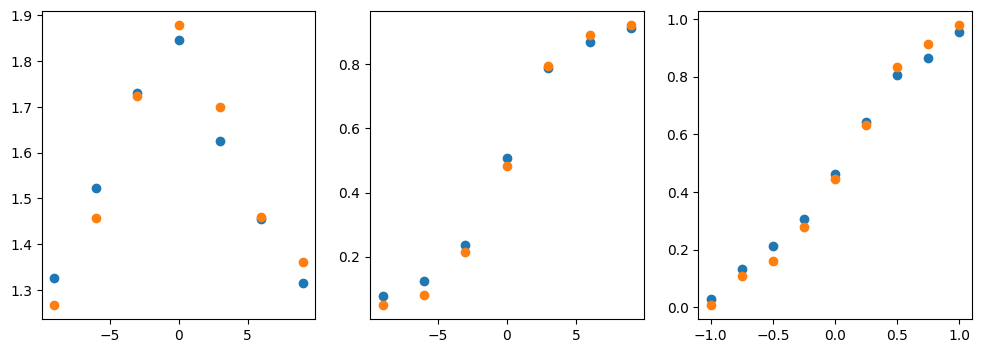

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

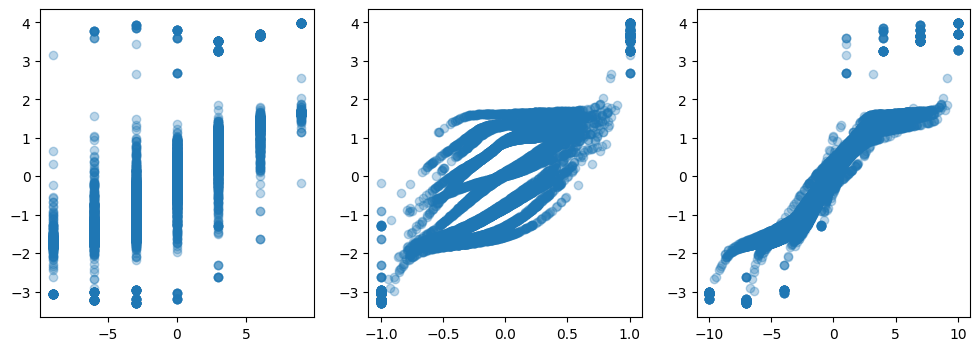

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);